In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/Users/ohheungchan/workspace/AI_Study/Paperwork/human+activity+recognition+using+smartphones/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/Users/ohheungchan/workspace/AI_Study/Paperwork/human+activity+recognition+using+smartphones/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [4]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [6]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [7]:

unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [8]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy
     

In [9]:
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)
     

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)
     

In [11]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]


In [13]:
# Model 1
model = Sequential()
model.add(LSTM(128, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               70656     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 87,942
Trainable params: 87,942
Non-trainable params: 0
_________________________________________________________________


In [14]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)
     

Epoch 1/10


2024-03-15 02:47:13.320708: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-03-15 02:47:14.210705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:47:14.345148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:47:19.914156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 1.2482 - accuracy: 0.4712

2024-03-15 02:47:35.693544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:47:35.747724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 24s 198ms/step - loss: 1.2482 - accuracy: 0.4712 - val_loss: 1.0550 - val_accuracy: 0.5422
Epoch 2/10
58/58 [==============================] - 3s 56ms/step - loss: 0.8826 - accuracy: 0.6341 - val_loss: 0.9222 - val_accuracy: 0.6383
Epoch 3/10
58/58 [==============================] - 3s 55ms/step - loss: 0.7760 - accuracy: 0.6730 - val_loss: 0.7043 - val_accuracy: 0.7103
Epoch 4/10
58/58 [==============================] - 3s 56ms/step - loss: 0.6175 - accuracy: 0.7414 - val_loss: 0.4887 - val_accuracy: 0.7956
Epoch 5/10
58/58 [==============================] - 3s 57ms/step - loss: 0.4597 - accuracy: 0.8262 - val_loss: 0.3633 - val_accuracy: 0.8740
Epoch 6/10
58/58 [==============================] - 3s 56ms/step - loss: 0.4611 - accuracy: 0.8373 - val_loss: 0.3831 - val_accuracy: 0.8572
Epoch 7/10
58/58 [==============================] - 3s 55ms/step - loss: 0.3123 - accuracy: 0.8920 - val_loss: 0.2483 - val_accuracy: 0.9075
Epoch 8/10
58/58 [====

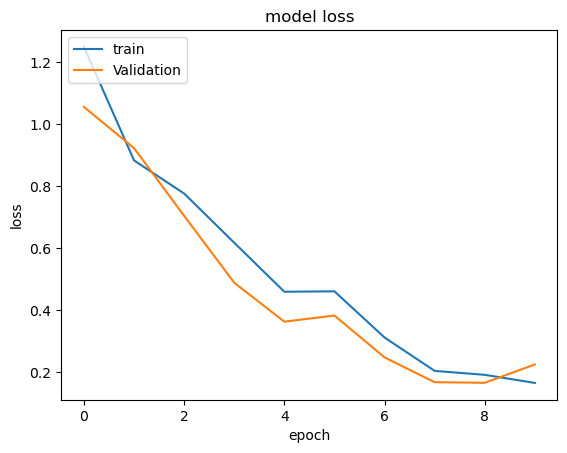

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

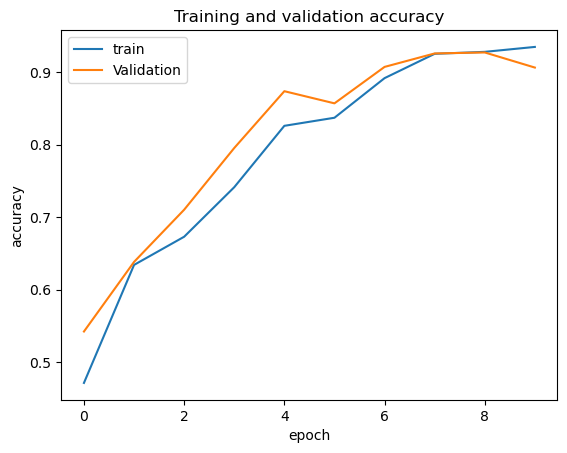

In [16]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

2024-03-15 02:48:37.836383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:48:37.880824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 5s 40ms/step
[[464   4   9   0  19   0]
 [ 21 445   5   0   0   0]
 [119  23 278   0   0   0]
 [  6   3   0 361 121   0]
 [  3   0   0  77 452   0]
 [  0  27   0   0   0 510]]
0.8517136070580251
0.850514601488082
              precision    recall  f1-score   support

           0       0.76      0.94      0.84       496
           1       0.89      0.94      0.91       471
           2       0.95      0.66      0.78       420
           3       0.82      0.74      0.78       491
           4       0.76      0.85      0.80       532
           5       1.00      0.95      0.97       537

    accuracy                           0.85      2947
   macro avg       0.86      0.85      0.85      2947
weighted avg       0.86      0.85      0.85      2947



<Axes: >

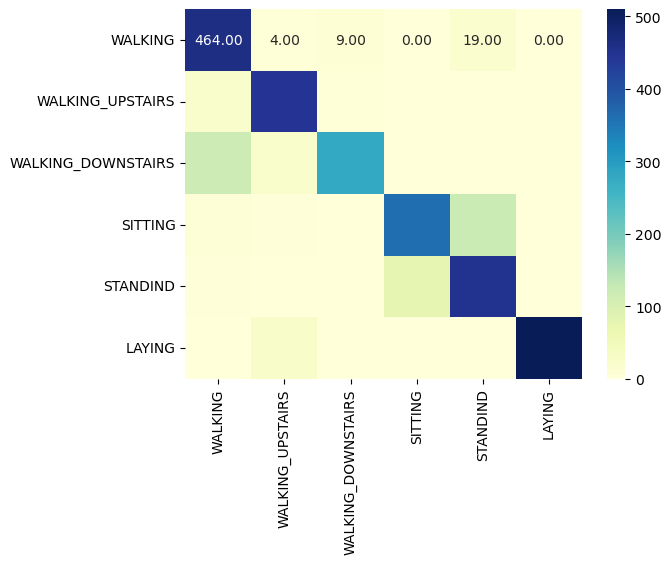

In [17]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

In [18]:

# Model 2
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_2 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 6)                 774       
                                                                 
Total params: 219,526
Trainable params: 219,526
Non-tr

In [19]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)
     

Epoch 1/10


2024-03-15 02:49:03.030695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:49:03.247042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:49:04.094852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:49:05.032478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:49:09.937780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 1.1766 - accuracy: 0.5064

2024-03-15 02:49:30.736580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:49:30.820100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:49:31.576013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 33s 348ms/step - loss: 1.1766 - accuracy: 0.5064 - val_loss: 0.8555 - val_accuracy: 0.6324
Epoch 2/10
58/58 [==============================] - 6s 97ms/step - loss: 0.7278 - accuracy: 0.6911 - val_loss: 0.6090 - val_accuracy: 0.7321
Epoch 3/10
58/58 [==============================] - 6s 96ms/step - loss: 0.5995 - accuracy: 0.7417 - val_loss: 0.4947 - val_accuracy: 0.7647
Epoch 4/10
58/58 [==============================] - 6s 97ms/step - loss: 0.4665 - accuracy: 0.8035 - val_loss: 0.5591 - val_accuracy: 0.7715
Epoch 5/10
58/58 [==============================] - 6s 97ms/step - loss: 0.3077 - accuracy: 0.8878 - val_loss: 0.2374 - val_accuracy: 0.9198
Epoch 6/10
58/58 [==============================] - 6s 97ms/step - loss: 0.2106 - accuracy: 0.9236 - val_loss: 0.1719 - val_accuracy: 0.9293
Epoch 7/10
58/58 [==============================] - 6s 97ms/step - loss: 0.1839 - accuracy: 0.9301 - val_loss: 0.2031 - val_accuracy: 0.9347
Epoch 8/10
58/58 [====

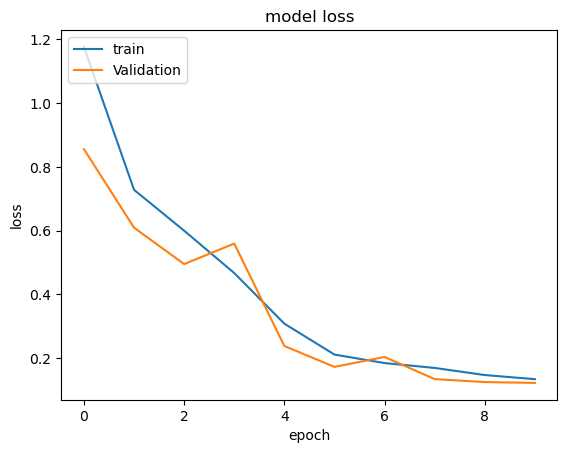

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

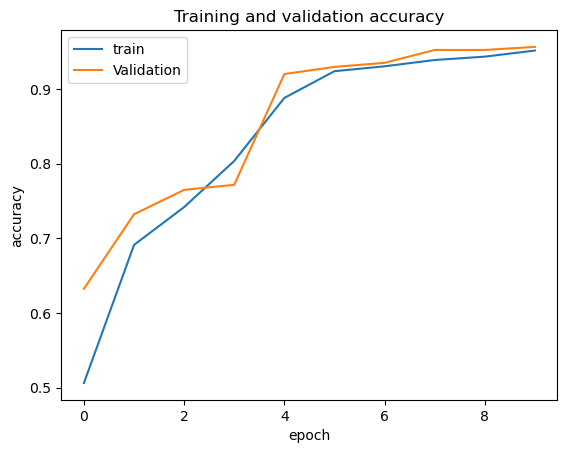

In [21]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

2024-03-15 02:50:43.354563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:50:43.427663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:50:44.185662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 7s 58ms/step
[[471  24   1   0   0   0]
 [ 52 411   7   0   1   0]
 [  0   3 417   0   0   0]
 [  5   0   0 387  99   0]
 [  7   0   0  99 426   0]
 [  0  18   5   0   0 514]]
0.8910756701730573
0.8909306708178736
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       496
           1       0.90      0.87      0.89       471
           2       0.97      0.99      0.98       420
           3       0.80      0.79      0.79       491
           4       0.81      0.80      0.81       532
           5       1.00      0.96      0.98       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



<Axes: >

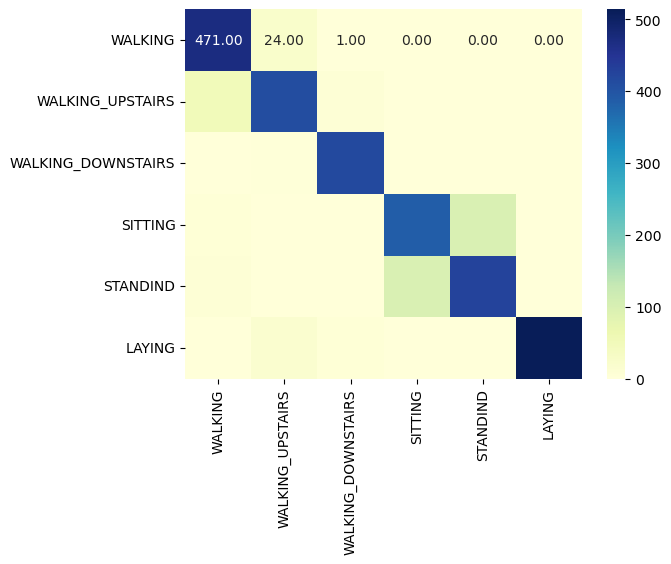

In [22]:

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

In [23]:

# Model 3
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_4 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_5 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_5 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_6 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [24]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)
     

Epoch 1/10


2024-03-15 02:51:02.565345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:51:02.874832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:51:03.649012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:51:04.439204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:51:05.287156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:51:10.194043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:51:15.136221: I tensorflow/core/grappler/optimizers/cust

58/58 [==============================] - ETA: 0s - loss: 1.1384 - accuracy: 0.5178

2024-03-15 02:51:43.481026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:51:43.590353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:51:44.351219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:51:45.115499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 48s 513ms/step - loss: 1.1384 - accuracy: 0.5178 - val_loss: 0.8928 - val_accuracy: 0.6269
Epoch 2/10
58/58 [==============================] - 8s 136ms/step - loss: 0.6887 - accuracy: 0.6921 - val_loss: 0.6604 - val_accuracy: 0.7117
Epoch 3/10
58/58 [==============================] - 8s 137ms/step - loss: 0.5811 - accuracy: 0.7431 - val_loss: 0.5890 - val_accuracy: 0.7362
Epoch 4/10
58/58 [==============================] - 8s 136ms/step - loss: 0.4864 - accuracy: 0.7724 - val_loss: 0.4141 - val_accuracy: 0.8228
Epoch 5/10
58/58 [==============================] - 8s 136ms/step - loss: 0.3754 - accuracy: 0.8373 - val_loss: 0.4584 - val_accuracy: 0.8155
Epoch 6/10
58/58 [==============================] - 8s 136ms/step - loss: 0.2690 - accuracy: 0.9003 - val_loss: 0.2146 - val_accuracy: 0.9220
Epoch 7/10
58/58 [==============================] - 8s 140ms/step - loss: 0.1706 - accuracy: 0.9370 - val_loss: 0.1561 - val_accuracy: 0.9442
Epoch 8/10
58/58

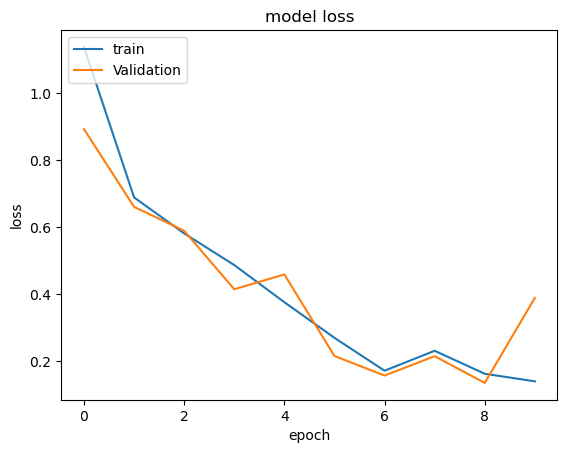

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
     

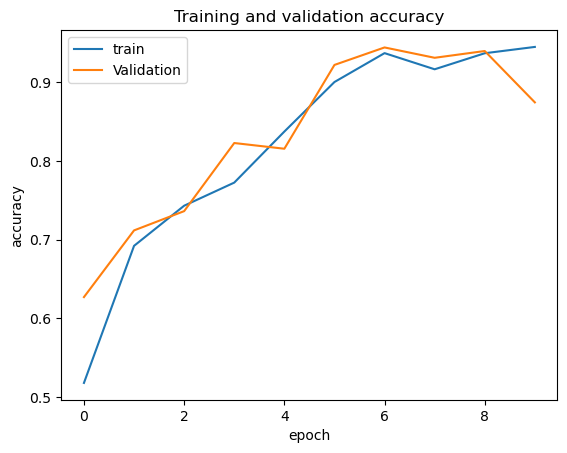

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

2024-03-15 02:53:19.572122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:53:19.673034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:53:20.420474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:53:21.176699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 11s 85ms/step
[[473  20   2   0   1   0]
 [ 65 396   4   1   5   0]
 [ 14 196 210   0   0   0]
 [  1   5   0 399  85   1]
 [  1   0   0 106 425   0]
 [  0  26   1  58   0 452]]
0.7991177468612148
0.7980607942317026
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       496
           1       0.62      0.84      0.71       471
           2       0.97      0.50      0.66       420
           3       0.71      0.81      0.76       491
           4       0.82      0.80      0.81       532
           5       1.00      0.84      0.91       537

    accuracy                           0.80      2947
   macro avg       0.83      0.79      0.79      2947
weighted avg       0.83      0.80      0.80      2947



<Axes: >

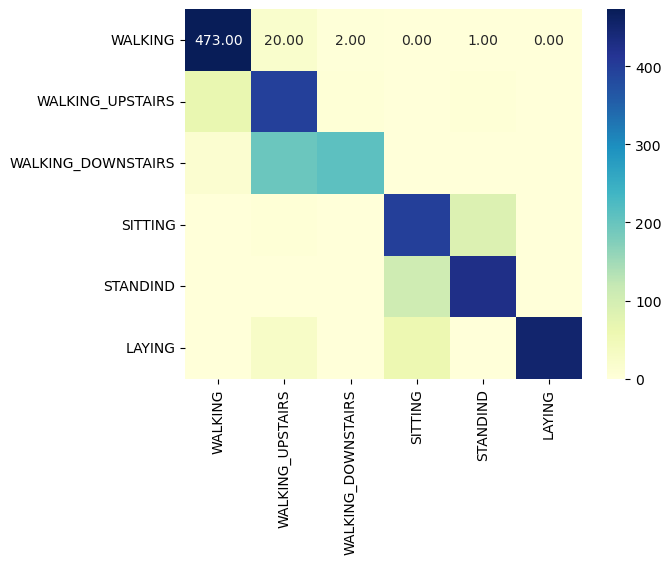

In [27]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

In [28]:
# Model 4
model = Sequential()
model.add(LSTM(128, return_sequences=True , input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True ))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_7 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_8 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_8 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_9 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_9 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_10 (LSTM)              (None, 128)              

In [29]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)
     

Epoch 1/10


2024-03-15 02:53:44.977863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:53:45.372383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:53:46.174833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:53:46.967649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:53:47.783430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:53:48.655850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:53:53.447421: I tensorflow/core/grappler/optimizers/cust

58/58 [==============================] - ETA: 0s - loss: 1.1901 - accuracy: 0.4807

2024-03-15 02:54:38.539760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:54:38.687087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:54:39.482674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:54:40.266614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:54:41.021180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 64s 670ms/step - loss: 1.1901 - accuracy: 0.4807 - val_loss: 0.7851 - val_accuracy: 0.6287
Epoch 2/10
58/58 [==============================] - 10s 174ms/step - loss: 0.6720 - accuracy: 0.6986 - val_loss: 0.5363 - val_accuracy: 0.7312
Epoch 3/10
58/58 [==============================] - 10s 174ms/step - loss: 0.4623 - accuracy: 0.7806 - val_loss: 0.3956 - val_accuracy: 0.7942
Epoch 4/10
58/58 [==============================] - 10s 174ms/step - loss: 0.3779 - accuracy: 0.8090 - val_loss: 0.3444 - val_accuracy: 0.8291
Epoch 5/10
58/58 [==============================] - 10s 174ms/step - loss: 0.2865 - accuracy: 0.8807 - val_loss: 0.1938 - val_accuracy: 0.9198
Epoch 6/10
58/58 [==============================] - 10s 175ms/step - loss: 0.2565 - accuracy: 0.9060 - val_loss: 0.2710 - val_accuracy: 0.8880
Epoch 7/10
58/58 [==============================] - 10s 176ms/step - loss: 0.3287 - accuracy: 0.8730 - val_loss: 0.1611 - val_accuracy: 0.9320
Epoch 8/10

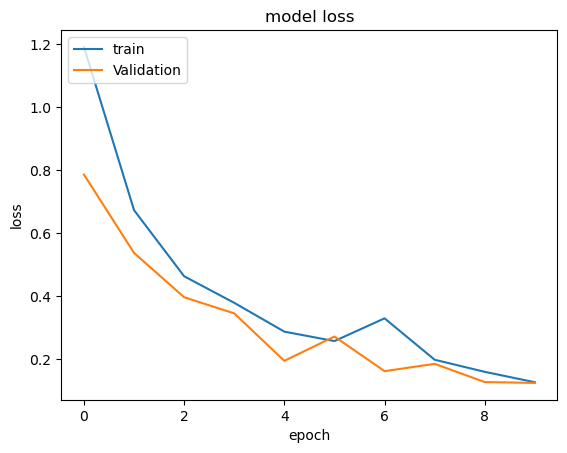

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
     

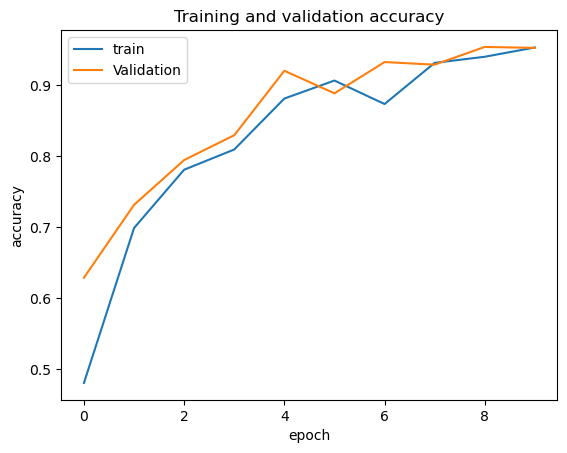

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

2024-03-15 02:56:44.807055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:56:44.945267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:56:45.727526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:56:46.516718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:56:47.319042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 15s 113ms/step
[[448  32   2   0  14   0]
 [ 33 435   3   0   0   0]
 [  2  20 398   0   0   0]
 [  2   3   0 410  74   2]
 [  1   0   0 115 416   0]
 [  0   4   0   0   0 533]]
0.8958262639972854
0.8961427073053262
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       496
           1       0.88      0.92      0.90       471
           2       0.99      0.95      0.97       420
           3       0.78      0.84      0.81       491
           4       0.83      0.78      0.80       532
           5       1.00      0.99      0.99       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



<Axes: >

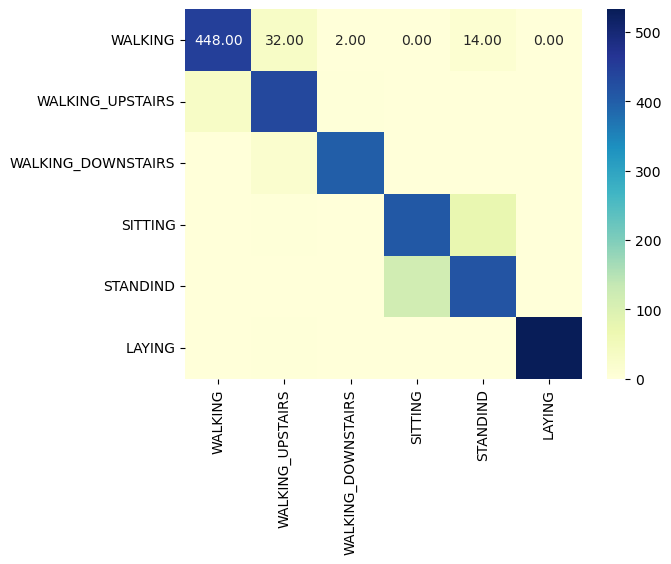

In [32]:

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

In [33]:
# Model 5
model = Sequential()
model.add(LSTM(128, return_sequences=True , input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True ))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 128, 128)          70656     
                                                                 
 dropout_11 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_12 (LSTM)              (None, 128, 128)          131584    
                                                                 
 dropout_12 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_13 (LSTM)              (None, 128, 128)          131584    
                                                                 
 dropout_13 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_14 (LSTM)              (None, 128, 128)         

In [34]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)
     

Epoch 1/10


2024-03-15 02:57:17.571818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:57:18.068047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:57:18.851415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:57:19.644845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:57:20.481335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:57:21.288437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:57:22.188023: I tensorflow/core/grappler/optimizers/cust

58/58 [==============================] - ETA: 0s - loss: 1.3607 - accuracy: 0.4191

2024-03-15 02:58:25.337758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:58:25.516987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:58:26.287245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:58:27.041330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:58:27.822759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 02:58:28.580537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 80s 844ms/step - loss: 1.3607 - accuracy: 0.4191 - val_loss: 1.0080 - val_accuracy: 0.5988
Epoch 2/10
58/58 [==============================] - 12s 215ms/step - loss: 0.7752 - accuracy: 0.6650 - val_loss: 0.6098 - val_accuracy: 0.7353
Epoch 3/10
58/58 [==============================] - 12s 215ms/step - loss: 0.5914 - accuracy: 0.7368 - val_loss: 0.7741 - val_accuracy: 0.6532
Epoch 4/10
58/58 [==============================] - 12s 214ms/step - loss: 0.5025 - accuracy: 0.7567 - val_loss: 0.3945 - val_accuracy: 0.8209
Epoch 5/10
58/58 [==============================] - 12s 215ms/step - loss: 0.3685 - accuracy: 0.8413 - val_loss: 0.5425 - val_accuracy: 0.7996
Epoch 6/10
58/58 [==============================] - 13s 216ms/step - loss: 0.3308 - accuracy: 0.8747 - val_loss: 0.3444 - val_accuracy: 0.8604
Epoch 7/10
58/58 [==============================] - 12s 215ms/step - loss: 0.2411 - accuracy: 0.9139 - val_loss: 0.2722 - val_accuracy: 0.9044
Epoch 8/10

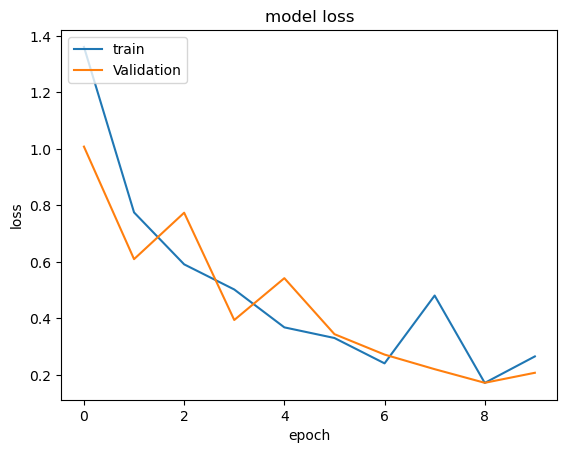

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

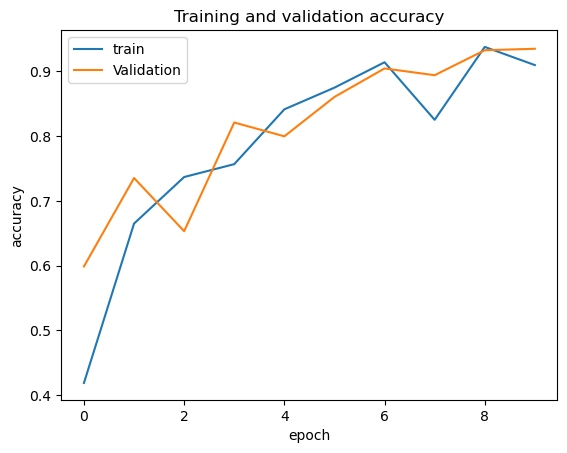

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

2024-03-15 03:00:52.169995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 03:00:52.344324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 03:00:53.159640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 03:00:53.965112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 03:00:54.738450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 03:00:55.509557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 18s 141ms/step
[[451  18  24   0   3   0]
 [ 31 415  24   0   1   0]
 [  0   1 419   0   0   0]
 [  0   1   0 443  47   0]
 [  2   0   0 137 393   0]
 [  1   5   0   0   0 531]]
0.8998982015609094
0.899416843760389
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       496
           1       0.94      0.88      0.91       471
           2       0.90      1.00      0.94       420
           3       0.76      0.90      0.83       491
           4       0.89      0.74      0.81       532
           5       1.00      0.99      0.99       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



<Axes: >

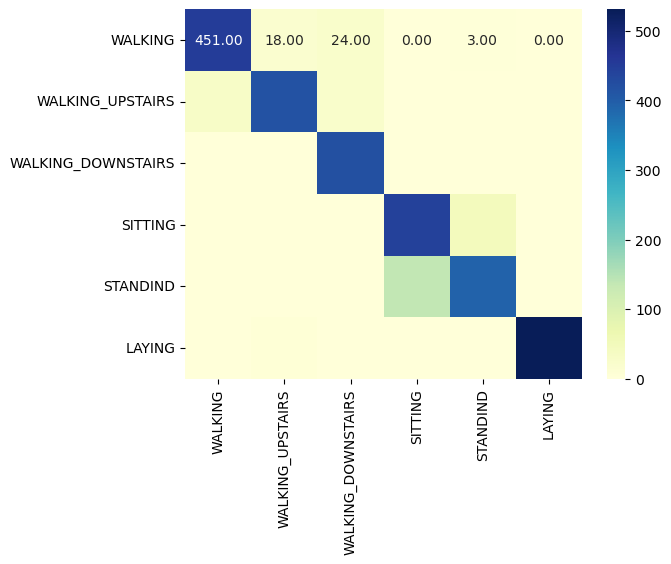

In [37]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')